In [1]:
import deepcore.nets as nets
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
#from deepcore.datasets import CIFAR10
from torchvision.datasets import CIFAR10
import torchvision.models as models
from utils import *
import deepcore.datasets as datasets_deepcore
import gc
import matplotlib.pyplot as plt
import numpy as np

class Args:
    device = 'cuda:0'
    print_freq = 1000
    gpu = [0]
args = Args()


# Define the path to the checkpoint file
#checkpoint_path = 'result/CIFAR10_MobileNetV3Small_Glister_exp0_epoch200_2023-04-30 16:20:56.585376_0.1_42.870000.ckpt'
#checkpoint_path = 'result/CIFAR10_MobileNetV3Small_Glister_exp0_epoch200_2023-04-30 18_59_25.654421_0.5_36.740000.ckpt'
#checkpoint_path = 'result/CIFAR10_InceptionV3_Glister_exp0_epoch200_2023-04-30 14:43:44.101066_0.1_57.730000.ckpt'
#checkpoint_path = 'result/result_harsh/CIFAR10_MobileNetV3Small_Cal_exp0_epoch200_2023-05-02 09:48:37.247423_0.1_58.230000.ckpt'
checkpoint_path = '/projectnb/ds563/hsharma/DeepCore/result/CIFAR10_MobileNetV3Small_Uniform_exp0_epoch200_2023-05-02 19:03:06.799824_0.5_67.190000.ckpt'

# Load the checkpoint file into a dictionary and specify the device to use
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# load checkpoint
try:
    print("=> Loading checkpoint '{}'".format(checkpoint_path))
    checkpoint = torch.load(checkpoint_path, map_location=device)
    assert {"exp", "epoch", "state_dict", "opt_dict", "best_acc1", "rec", "subset", "sel_args"} <= set(
        checkpoint.keys())
    assert 'indices' in checkpoint["subset"].keys()
    start_exp = checkpoint['exp']
    start_epoch = checkpoint["epoch"]
except AssertionError:
    try:
        assert {"exp", "subset", "sel_args"} <= set(checkpoint.keys())
        assert 'indices' in checkpoint["subset"].keys()
        print("=> The checkpoint only contains the subset, training will start from the begining")
        start_exp = checkpoint['exp']
        start_epoch = 0
    except AssertionError:
        print("=> Failed to load the checkpoint, an empty one will be created")
        checkpoint = {}
        start_exp = 0
        start_epoch = 0

# Create a new instance of the Mobilenetv3 Small model and load the pre-trained weights onto the GPU
#model = models.mobilenet_v3_small(pretrained=False)
#model = models.inception_v3(pretrained=False)

channel, im_size, num_classes, class_names, mean, std, dst_train, dst_test = datasets_deepcore.__dict__["CIFAR10"] \
            ("data")

model = nets.__dict__['MobileNetV3Small'] \
            (channel, num_classes, im_size).to(args.device)

torch.cuda.set_device(args.gpu[0])
model = nets.nets_utils.MyDataParallel(model, device_ids=args.gpu)
if 'module' not in list(checkpoint['state_dict'].keys())[0]:
    new_state_dict = {}
    for key, value in checkpoint['state_dict'].items():
        # Add the "module" prefix to the key
        new_key = 'module.' + key
        new_state_dict[new_key] = value

    #model = torch.nn.DataParallel(model)  # wrap the model with DataParallel
    model.load_state_dict(new_state_dict)
    model.to(device)
    print("{} model is loaded!".format(model.module._get_name()))
else:
    model.load_state_dict(checkpoint['state_dict'])
    model.to(device)
    print("{} model is loaded!".format(model._get_name()))
    
gc.collect()
import torchvision

=> Loading checkpoint '/projectnb/ds563/hsharma/DeepCore/result/CIFAR10_MobileNetV3Small_Uniform_exp0_epoch200_2023-05-02 19:03:06.799824_0.5_67.190000.ckpt'
Files already downloaded and verified
Files already downloaded and verified
MobileNetV3_32x32 model is loaded!


In [2]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)

use_cuda=True
epsilons = [0, .05, .1]
mean = [0.4914, 0.4822, 0.4465]
std = [0.2470, 0.2435, 0.2616]
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])
data_path = "./data"
# Load the CIFAR10 dataset
#transform = transforms.Compose([transforms.ToTensor(),
#                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
testset = datasets.CIFAR10(root=data_path, train=False, download=True, transform=transform)

#dst_train = datasets.CIFAR10(data_path, train=True, download=True, transform=transform)
#dst_test = datasets.CIFAR10(data_path, train=False, download=True, transform=transform)

#testloader = torch.utils.data.DataLoader(dst_test, batch_size=1, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True)

# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    #if epsilon!=0:
    #    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image


def test_attack(model, device, test_loader, epsilon ):
    # Accuracy counter
    correct = 0
    adv_examples = []
    ctr=0
    # Loop over all examples in test set
    
    for data, target in test_loader:
        ctr+=1
        if ctr%1000 == 0:
            print("Example: {}/{}".format(ctr, len(test_loader)))
        # Send the data and label to the device
        data, target = data.to(device), target.to(device)
        data.requires_grad = True
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if init_pred.item() != target.item():
            continue
        loss = F.nll_loss(output, target)
        #loss = criterion(output, target).mean()
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)
        output = model(perturbed_data)
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

def test_attack_modified(model, device, test_loader, epsilon ):
    criterion = nn.CrossEntropyLoss()
    batch_time = AverageMeter('Time', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    
    # Accuracy counter
    correct = 0
    adv_examples = []
    ctr=0
    # Loop over all examples in test set
    end = time.time()
    for data, target in test_loader:
        ctr+=1
        if ctr%1000 == 0:
            print("Example: {}/{}".format(ctr, len(test_loader)))
        # Send the data and label to the device
        data, target = data.to(device), target.to(device)
        data.requires_grad = True
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if init_pred.item() != target.item():
            continue
        #loss = F.nll_loss(output, target)
        loss = criterion(output, target).mean()
        

        
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)
        output = model(perturbed_data)
        
        prec1 = accuracy(output.data, target, topk=(1,))[0]
        losses.update(loss.data.item(), data.size(0))
        top1.update(prec1.item(), data.size(0))
        
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        batch_time.update(time.time() - end)
        end = time.time()
        if ctr % args.print_freq == 0:
            print('Test: [{0}/{1}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                ctr, len(test_loader), batch_time=batch_time, loss=losses,
                top1=top1))

    print(' * Prec@1 {top1.avg:.3f}'.format(top1=top1))
        

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples


# Measure accuracy and record loss


Files already downloaded and verified


In [ ]:
accuracies = []
examples = []
model.eval()

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test_attack_modified(model, device, testloader, eps)
    accuracies.append(acc)
    examples.append(ex)

Example: 1000/10000
Test: [1000/10000]	Time 0.025 (0.027)	Loss 0.3120 (0.3026)	Prec@1 100.000 (100.000)
Example: 2000/10000
Test: [2000/10000]	Time 0.024 (0.027)	Loss 0.4312 (0.3136)	Prec@1 100.000 (100.000)
Example: 3000/10000
Test: [3000/10000]	Time 0.031 (0.027)	Loss 0.3687 (0.3169)	Prec@1 100.000 (100.000)
Example: 4000/10000
Test: [4000/10000]	Time 0.023 (0.027)	Loss 0.5501 (0.3177)	Prec@1 100.000 (100.000)
Example: 5000/10000
Test: [5000/10000]	Time 0.023 (0.027)	Loss 0.5623 (0.3218)	Prec@1 100.000 (100.000)
Example: 6000/10000
Test: [6000/10000]	Time 0.024 (0.027)	Loss 1.1257 (0.3227)	Prec@1 100.000 (100.000)
Example: 7000/10000
Test: [7000/10000]	Time 0.033 (0.027)	Loss 0.3180 (0.3248)	Prec@1 100.000 (100.000)
Example: 8000/10000
Test: [8000/10000]	Time 0.023 (0.027)	Loss 0.3602 (0.3276)	Prec@1 100.000 (100.000)
Example: 9000/10000
Example: 10000/10000
 * Prec@1 100.000
Epsilon: 0	Test Accuracy = 6719 / 10000 = 0.6719
Example: 1000/10000
Test: [1000/10000]	Time 0.023 (0.027)	Lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

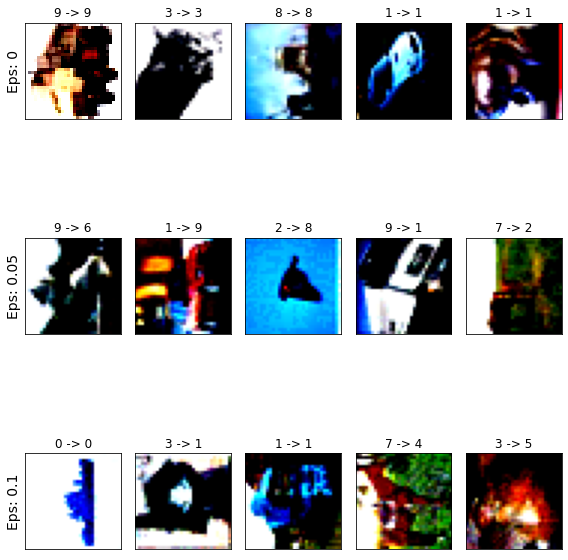

In [7]:
import matplotlib.pyplot as plt

cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex.T)
plt.tight_layout()
plt.show()

In [ ]:
#RANDOM
import matplotlib.pyplot as plt

cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex.T)
plt.tight_layout()
plt.show()

In [ ]:
airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks

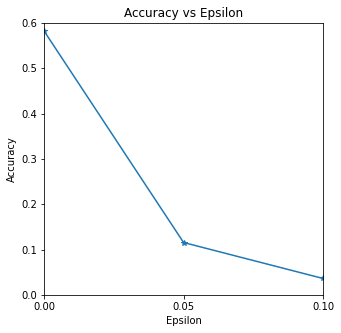

In [11]:
#RANDOM
import numpy as np
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.ylim(0, 0.6)
plt.xlim(0, 0.1)
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

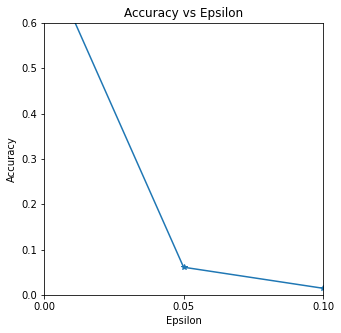

In [19]:
import numpy as np
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.ylim(0, 0.6)
plt.xlim(0, 0.1)
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

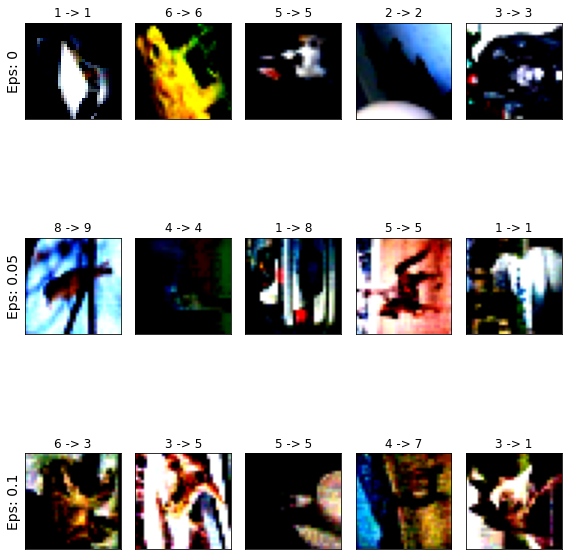

In [12]:
import matplotlib.pyplot as plt

cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex.T)
plt.tight_layout()
plt.show()

In [ ]:
0. airplanes, 1. cars, 2. birds, 3. cats, 4. deer, 5. dogs, 6. frogs, 7. horses, 8. ships, and 9. trucks

In [ ]:
# Looping over all best checkpoints

In [4]:
checkpoints = ['CIFAR10_MobileNetV3Small_Cal_exp0_epoch200_2023-05-03 00:45:20.069347_0.1_58.540000.ckpt',
              'CIFAR10_MobileNetV3Small_Cal_exp0_epoch200_2023-05-03 01:03:12.121117_0.5_74.230000.ckpt',
              'CIFAR10_MobileNetV3Small_ContextualDiversity_exp0_epoch200_2023-05-03 02:18:40.634070_0.1_45.680000.ckpt',
              'CIFAR10_MobileNetV3Small_ContextualDiversity_exp0_epoch200_2023-05-02 19:27:29.919446_0.5_64.050000.ckpt',
              'CIFAR10_MobileNetV3Small_Glister_exp0_epoch200_2023-05-02 17:31:11.579179_0.1_43.630000.ckpt',
              'CIFAR10_MobileNetV3Small_Glister_exp0_epoch200_2023-05-03 01:54:48.875219_0.5_73.210000.ckpt',
              'CIFAR10_MobileNetV3Small_GraNd_exp0_epoch200_2023-05-02 20:38:22.294005_0.1_29.130000.ckpt',
              'CIFAR10_MobileNetV3Small_GraNd_exp0_epoch200_2023-05-02 21:50:53.361318_0.5_51.440000.ckpt',
              'CIFAR10_MobileNetV3Small_Submodular_exp0_epoch200_2023-05-03 03:44:46.519819_0.1_60.710000.ckpt',
              'CIFAR10_MobileNetV3Small_Submodular_exp0_epoch200_2023-05-03 03:53:58.739736_0.5_76.600000.ckpt',
              'CIFAR10_MobileNetV3Small_Uniform_exp0_epoch200_2023-05-02 18:42:33.827203_0.1_59.680000.ckpt',
              'CIFAR10_MobileNetV3Small_Uniform_exp0_epoch200_2023-05-03 03:07:20.847888_0.5_76.040000.ckpt']

abs_path = '/projectnb/ds563/hsharma/DeepCore/result/'
import deepcore.nets as nets
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
#from deepcore.datasets import CIFAR10
from torchvision.datasets import CIFAR10
import torchvision.models as models
from utils import *
import deepcore.datasets as datasets_deepcore
import gc
import matplotlib.pyplot as plt
import numpy as np
import torchvision

class Args:
    device = 'cuda:0'
    print_freq = 10000
    gpu = [0]
args = Args()

accuracies = []
examples = []

for checkpoint_path in checkpoints:
    checkpoint_path = abs_path+checkpoint_path
    # Load the checkpoint file into a dictionary and specify the device to use
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    # load checkpoint
    try:
        print("=> Loading checkpoint '{}'".format(checkpoint_path))
        checkpoint = torch.load(checkpoint_path, map_location=device)
        assert {"exp", "epoch", "state_dict", "opt_dict", "best_acc1", "rec", "subset", "sel_args"} <= set(
            checkpoint.keys())
        assert 'indices' in checkpoint["subset"].keys()
        start_exp = checkpoint['exp']
        start_epoch = checkpoint["epoch"]
    except AssertionError:
        try:
            assert {"exp", "subset", "sel_args"} <= set(checkpoint.keys())
            assert 'indices' in checkpoint["subset"].keys()
            print("=> The checkpoint only contains the subset, training will start from the begining")
            start_exp = checkpoint['exp']
            start_epoch = 0
        except AssertionError:
            print("=> Failed to load the checkpoint, an empty one will be created")
            checkpoint = {}
            start_exp = 0
            start_epoch = 0

    channel, im_size, num_classes, class_names, mean, std, dst_train, dst_test = datasets_deepcore.__dict__["CIFAR10"] \
                ("data")

    model = nets.__dict__['MobileNetV3Small'] \
                (channel, num_classes, im_size).to(args.device)

    torch.cuda.set_device(args.gpu[0])
    model = nets.nets_utils.MyDataParallel(model, device_ids=args.gpu)
    if 'module' not in list(checkpoint['state_dict'].keys())[0]:
        new_state_dict = {}
        for key, value in checkpoint['state_dict'].items():
            # Add the "module" prefix to the key
            new_key = 'module.' + key
            new_state_dict[new_key] = value

        #model = torch.nn.DataParallel(model)  # wrap the model with DataParallel
        model.load_state_dict(new_state_dict)
        model.to(device)
        print("{} model is loaded!".format(model.module._get_name()))
    else:
        model.load_state_dict(checkpoint['state_dict'])
        model.to(device)
        print("{} model is loaded!".format(model._get_name()))

    model.eval()
    temp_acc = []
    temp_ex = []
    # Run test for each epsilon
    for eps in epsilons:
        acc, ex = test_attack_modified(model, device, testloader, eps)
        #accuracies.append(acc)
        #examples.append(ex)
        temp_acc.append(acc)
        temp_ex.append(ex)
        
    accuracies.append(temp_acc)
    examples.append(temp_ex)

=> Loading checkpoint '/projectnb/ds563/hsharma/DeepCore/result/CIFAR10_MobileNetV3Small_Cal_exp0_epoch200_2023-05-03 00:45:20.069347_0.1_58.540000.ckpt'
Files already downloaded and verified
Files already downloaded and verified
MobileNetV3_32x32 model is loaded!
Example: 1000/10000
Example: 2000/10000
Example: 3000/10000
Example: 4000/10000
Example: 5000/10000
Example: 6000/10000
Example: 7000/10000
Example: 8000/10000
Example: 9000/10000
Example: 10000/10000
 * Prec@1 100.000
Epsilon: 0	Test Accuracy = 5854 / 10000 = 0.5854
Example: 1000/10000
Example: 2000/10000
Example: 3000/10000
Example: 4000/10000
Example: 5000/10000
Example: 6000/10000
Example: 7000/10000
Example: 8000/10000
Example: 9000/10000
Example: 10000/10000
Test: [10000/10000]	Time 0.105 (0.030)	Loss 0.3484 (0.1738)	Prec@1 0.000 (13.683)
 * Prec@1 13.683
Epsilon: 0.05	Test Accuracy = 801 / 10000 = 0.0801
Example: 1000/10000
Example: 2000/10000
Example: 3000/10000
Example: 4000/10000
Example: 5000/10000
Example: 6000/10

Example: 1000/10000
Example: 2000/10000
Example: 3000/10000
Example: 4000/10000
Example: 5000/10000
Example: 6000/10000
Example: 7000/10000
Example: 8000/10000
Example: 9000/10000
Example: 10000/10000
 * Prec@1 4.499
Epsilon: 0.1	Test Accuracy = 131 / 10000 = 0.0131
=> Loading checkpoint '/projectnb/ds563/hsharma/DeepCore/result/CIFAR10_MobileNetV3Small_GraNd_exp0_epoch200_2023-05-02 21:50:53.361318_0.5_51.440000.ckpt'
Files already downloaded and verified
Files already downloaded and verified
MobileNetV3_32x32 model is loaded!
Example: 1000/10000
Example: 2000/10000
Example: 3000/10000
Example: 4000/10000
Example: 5000/10000
Example: 6000/10000
Example: 7000/10000
Example: 8000/10000
Example: 9000/10000
Example: 10000/10000
 * Prec@1 100.000
Epsilon: 0	Test Accuracy = 5145 / 10000 = 0.5145
Example: 1000/10000
Example: 2000/10000
Example: 3000/10000
Example: 4000/10000
Example: 5000/10000
Example: 6000/10000
Example: 7000/10000
Example: 8000/10000
Example: 9000/10000
Example: 10000/100

In [5]:
print(accuracies)

[[0.5854, 0.0801, 0.0269], [0.7423, 0.0883, 0.0227], [0.4568, 0.0173, 0.0029], [0.6403, 0.0527, 0.0244], [0.4363, 0.0392, 0.0137], [0.7322, 0.0397, 0.0092], [0.2912, 0.0234, 0.0131], [0.5145, 0.038, 0.022], [0.6071, 0.0678, 0.0128], [0.766, 0.0362, 0.0057], [0.5968, 0.0627, 0.0158], [0.7604, 0.081, 0.027]]


In [9]:
accuracies = [[0.5854, 0.0801, 0.0269], [0.7423, 0.0883, 0.0227], [0.4568, 0.0173, 0.0029], [0.6403, 0.0527, 0.0244], [0.4363, 0.0392, 0.0137], [0.7322, 0.0397, 0.0092], [0.2912, 0.0234, 0.0131], [0.5145, 0.038, 0.022], [0.6071, 0.0678, 0.0128], [0.766, 0.0362, 0.0057], [0.5968, 0.0627, 0.0158], [0.7604, 0.081, 0.027]]

In [12]:
epsilons = [0, 0.05, 0.1]

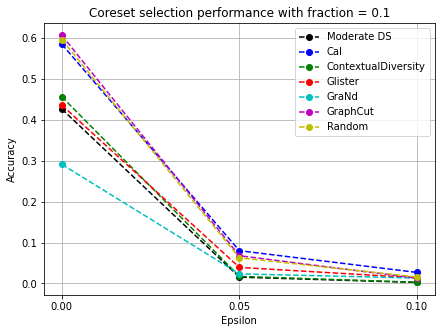

In [13]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (7,5)
cal_0 = accuracies[0]
cal_1 = accuracies[1]
cd_0 =accuracies[2]
cd_1 = accuracies[3]
glister_0 = accuracies[4]
glister_1 = accuracies[5]
grand_0 =accuracies[6]
grand_1 = accuracies[7]
submod_0 = accuracies[8]
submod_1 = accuracies[9]
uniform_0=accuracies[10]
uniform_1=accuracies[11]
mds_0 = [0.4268, 0.0153, 0.0024]
mds_1 = [0.77, 0.07, 0.04]

xaxis = epsilons

plt.plot(xaxis, mds_0, '--ko', label="Moderate DS")
plt.plot(xaxis, cal_0,'--bo', label="Cal")
plt.plot(xaxis, cd_0,'--go', label="ContextualDiversity")
plt.plot(xaxis, glister_0,'--ro', label="Glister")
plt.plot(xaxis, grand_0,'--co', label="GraNd")
plt.plot(xaxis, submod_0,'--mo', label="GraphCut")
plt.plot(xaxis, uniform_0,'--yo', label="Random")

plt.xticks(epsilons)
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.grid()
plt.title("Coreset selection performance with fraction = 0.1")
plt.legend()
plt.savefig('/projectnb/ds563/gmharsh/frac_10.jpg', bbox_inches='tight')
plt.show()
plt.close()

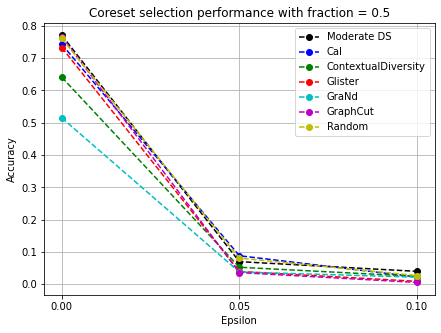

In [14]:
plt.plot(xaxis, mds_1, '--ko', label="Moderate DS")
plt.plot(xaxis, cal_1,'--bo', label="Cal")
plt.plot(xaxis, cd_1,'--go', label="ContextualDiversity")
plt.plot(xaxis, glister_1,'--ro', label="Glister")
plt.plot(xaxis, grand_1,'--co', label="GraNd")
plt.plot(xaxis, submod_1,'--mo', label="GraphCut")
plt.plot(xaxis, uniform_1,'--yo', label="Random")
plt.xticks(epsilons)
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.grid()
plt.title("Coreset selection performance with fraction = 0.5")
plt.legend()
plt.savefig('/projectnb/ds563/gmharsh/frac_50.jpg', bbox_inches='tight')
plt.show()

plt.close()

In [ ]:
######### testing PGD

In [5]:
!pip install torchattacks

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 154 kB 8.2 MB/s eta 0:00:01
You should consider upgrading via the '/share/pkg.7/python3/3.7.10/install/bin/python3.7 -m pip install --upgrade pip' command.


In [7]:
import torch
import torchvision
import torchattacks

checkpoints = ['/projectnb/ds563/hsharma/DeepCore/result/moderate_ds/mobilenet_cifar10_prune_0.5_resnet.pth',
              'CIFAR10_MobileNetV3Small_Cal_exp0_epoch200_2023-05-03 00:45:20.069347_0.1_58.540000.ckpt',
              'CIFAR10_MobileNetV3Small_Cal_exp0_epoch200_2023-05-03 01:03:12.121117_0.5_74.230000.ckpt',
              'CIFAR10_MobileNetV3Small_ContextualDiversity_exp0_epoch200_2023-05-03 02:18:40.634070_0.1_45.680000.ckpt',
              'CIFAR10_MobileNetV3Small_ContextualDiversity_exp0_epoch200_2023-05-02 19:27:29.919446_0.5_64.050000.ckpt',
              'CIFAR10_MobileNetV3Small_Glister_exp0_epoch200_2023-05-02 17:31:11.579179_0.1_43.630000.ckpt',
              'CIFAR10_MobileNetV3Small_Glister_exp0_epoch200_2023-05-03 01:54:48.875219_0.5_73.210000.ckpt',
              'CIFAR10_MobileNetV3Small_GraNd_exp0_epoch200_2023-05-02 20:38:22.294005_0.1_29.130000.ckpt',
              'CIFAR10_MobileNetV3Small_GraNd_exp0_epoch200_2023-05-02 21:50:53.361318_0.5_51.440000.ckpt',
              'CIFAR10_MobileNetV3Small_Submodular_exp0_epoch200_2023-05-03 03:44:46.519819_0.1_60.710000.ckpt',
              'CIFAR10_MobileNetV3Small_Submodular_exp0_epoch200_2023-05-03 03:53:58.739736_0.5_76.600000.ckpt',
              'CIFAR10_MobileNetV3Small_Uniform_exp0_epoch200_2023-05-02 18:42:33.827203_0.1_59.680000.ckpt',
              'CIFAR10_MobileNetV3Small_Uniform_exp0_epoch200_2023-05-03 03:07:20.847888_0.5_76.040000.ckpt']

abs_path = '/projectnb/ds563/hsharma/DeepCore/result/'
import deepcore.nets as nets
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
#from deepcore.datasets import CIFAR10
from torchvision.datasets import CIFAR10
import torchvision.models as models
from utils import *
import deepcore.datasets as datasets_deepcore
import gc
import matplotlib.pyplot as plt
import numpy as np
import torchvision

class Args:
    device = 'cuda:0'
    print_freq = 10000
    gpu = [0]
args = Args()

accuracies = []
examples = []

epsilons = [8/255, 10/255, 20/255]

for checkpoint_path in checkpoints:
    if checkpoint_path != checkpoints[0]:
        checkpoint_path = abs_path+checkpoint_path
    # Load the checkpoint file into a dictionary and specify the device to use
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    # load checkpoint
    if checkpoint_path != checkpoints[0]:
        try:
            print("=> Loading checkpoint '{}'".format(checkpoint_path))
            checkpoint = torch.load(checkpoint_path, map_location=device)
            assert {"exp", "epoch", "state_dict", "opt_dict", "best_acc1", "rec", "subset", "sel_args"} <= set(
                checkpoint.keys())
            assert 'indices' in checkpoint["subset"].keys()
            start_exp = checkpoint['exp']
            start_epoch = checkpoint["epoch"]
        except AssertionError:
            try:
                assert {"exp", "subset", "sel_args"} <= set(checkpoint.keys())
                assert 'indices' in checkpoint["subset"].keys()
                print("=> The checkpoint only contains the subset, training will start from the begining")
                start_exp = checkpoint['exp']
                start_epoch = 0
            except AssertionError:
                print("=> Failed to load the checkpoint, an empty one will be created")
                checkpoint = {}
                start_exp = 0
                start_epoch = 0
    else:
        checkpoint = torch.load(checkpoint_path, map_location=device)

    channel, im_size, num_classes, class_names, mean, std, dst_train, dst_test = datasets_deepcore.__dict__["CIFAR10"] \
                ("data")

    model = nets.__dict__['MobileNetV3Small'] \
                (channel, num_classes, im_size).to(args.device)

    torch.cuda.set_device(args.gpu[0])
    model = nets.nets_utils.MyDataParallel(model, device_ids=args.gpu)
    if 'module' not in list(checkpoint['state_dict'].keys())[0]:
        new_state_dict = {}
        for key, value in checkpoint['state_dict'].items():
            # Add the "module" prefix to the key
            new_key = 'module.' + key
            new_state_dict[new_key] = value

        #model = torch.nn.DataParallel(model)  # wrap the model with DataParallel
        model.load_state_dict(new_state_dict)
        model.to(device)
        print("{} model is loaded!".format(model.module._get_name()))
    else:
        model.load_state_dict(checkpoint['state_dict'])
        model.to(device)
        print("{} model is loaded!".format(model._get_name()))

    model.eval()


    # Define the PGD attack parameters
    for i in range(len(epsilons)):
        attack = torchattacks.PGD(model, eps=epsilons[i], alpha=2/255, steps=10)

        # Load the test dataset and apply normalization
        mean = [0.4914, 0.4822, 0.4465]
        std = [0.2470, 0.2435, 0.2616]
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])
        data_path = "./data"
        # Load the CIFAR10 dataset
        testset = datasets.CIFAR10(root=data_path, train=False, download=True, transform=transform)
        testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True, num_workers=15)


        # Loop through the test dataloader and get the predicted labels
        correct = 0
        total = 0
        for images, labels in testloader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Generate an adversarial example using PGD attack and obtain its predicted label
            adv_images = attack(images, labels)
            outputs = model(adv_images)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

        print("eps: {}".format(epsilons[i]))
        print('Accuracy of the model on the test images: %d %%' % (100 * correct / total))

Files already downloaded and verified
Files already downloaded and verified
MobileNetV3_32x32 model is loaded!
Files already downloaded and verified


ValueError: Input must have a range [0, 1] (max: 1.741058111190796, min: -1.9259666204452515)

In [ ]:

    temp_acc = []
    temp_ex = []
    # Run test for each epsilon
    for eps in epsilons:
        acc, ex = test_attack_modified(model, device, testloader, eps)
        #accuracies.append(acc)
        #examples.append(ex)
        temp_acc.append(acc)
        temp_ex.append(ex)
        
    accuracies.append(temp_acc)
    examples.append(temp_ex)

In [ ]:
### TESTING SPECIAL MOBILENETV3-SMALL on RESNET CORESET with FRACTION 0.5

In [17]:
import deepcore.nets as nets
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
#from deepcore.datasets import CIFAR10
from torchvision.datasets import CIFAR10
import torchvision.models as models
from utils import *
import deepcore.datasets as datasets_deepcore
import gc

class Args:
    device = 'cuda:0'
    print_freq = 1000
    gpu = [0]
args = Args()


# Define the path to the checkpoint file
#checkpoint_path = 'result/CIFAR10_MobileNetV3Small_Glister_exp0_epoch200_2023-04-30 16:20:56.585376_0.1_42.870000.ckpt'
#checkpoint_path = 'result/CIFAR10_MobileNetV3Small_Glister_exp0_epoch200_2023-04-30 18_59_25.654421_0.5_36.740000.ckpt'
#checkpoint_path = 'result/CIFAR10_InceptionV3_Glister_exp0_epoch200_2023-04-30 14:43:44.101066_0.1_57.730000.ckpt'
#checkpoint_path = 'result/result_harsh/CIFAR10_MobileNetV3Small_Cal_exp0_epoch200_2023-05-02 09:48:37.247423_0.1_58.230000.ckpt'

#checkpoint_path = 'result/result_harsh/moderate_ds/mobilenetv3_cifar10_0.5_selectedresnet.pth'
checkpoint_path = '/projectnb/ds563/hsharma/DeepCore/result/moderate_ds/mobilenet_cifar10_prune_0.5_resnet.pth'

# Load the checkpoint file into a dictionary and specify the device to use
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# load checkpoint
'''try:
    print("=> Loading checkpoint '{}'".format(checkpoint_path))
    checkpoint = torch.load(checkpoint_path, map_location=device)
    assert {"exp", "epoch", "state_dict", "opt_dict", "best_acc1", "rec", "subset", "sel_args"} <= set(
        checkpoint.keys())
    assert 'indices' in checkpoint["subset"].keys()
    start_exp = checkpoint['exp']
    start_epoch = checkpoint["epoch"]
except AssertionError:
    try:
        assert {"exp", "subset", "sel_args"} <= set(checkpoint.keys())
        assert 'indices' in checkpoint["subset"].keys()
        print("=> The checkpoint only contains the subset, training will start from the begining")
        start_exp = checkpoint['exp']
        start_epoch = 0
    except AssertionError:
        print("=> Failed to load the checkpoint, an empty one will be created")
        checkpoint = {}
        start_exp = 0
        start_epoch = 0'''

checkpoint = torch.load(checkpoint_path, map_location=device)

# Create a new instance of the Mobilenetv3 Small model and load the pre-trained weights onto the GPU
#model = models.mobilenet_v3_small(pretrained=False)
#model = models.inception_v3(pretrained=False)

channel, im_size, num_classes, class_names, mean, std, dst_train, dst_test = datasets_deepcore.__dict__["CIFAR10"] \
            ("data")

model = nets.__dict__['MobileNetV3Small'] \
            (channel, num_classes, im_size).to(args.device)

torch.cuda.set_device(args.gpu[0])
model = nets.nets_utils.MyDataParallel(model, device_ids=args.gpu)
if 'module' not in list(checkpoint['state_dict'].keys())[0]:
    new_state_dict = {}
    for key, value in checkpoint['state_dict'].items():
        # Add the "module" prefix to the key
        new_key = 'module.' + key
        new_state_dict[new_key] = value

    #model = torch.nn.DataParallel(model)  # wrap the model with DataParallel
    model.load_state_dict(new_state_dict)
    model.to(device)
    print("{} model is loaded!".format(model.module._get_name()))
else:
    model.load_state_dict(checkpoint['state_dict'])
    model.to(device)
    print("{} model is loaded!".format(model._get_name()))
    
gc.collect()
import torchvision

class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)

use_cuda=True
epsilons = [0, .05, .1]
mean = [0.4914, 0.4822, 0.4465]
std = [0.2470, 0.2435, 0.2616]
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])
data_path = "./data"
# Load the CIFAR10 dataset
#transform = transforms.Compose([transforms.ToTensor(),
#                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
testset = datasets.CIFAR10(root=data_path, train=False, download=True, transform=transform)

#dst_train = datasets.CIFAR10(data_path, train=True, download=True, transform=transform)
#dst_test = datasets.CIFAR10(data_path, train=False, download=True, transform=transform)

#testloader = torch.utils.data.DataLoader(dst_test, batch_size=1, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True)

# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    #if epsilon!=0:
    #    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

def test_attack_modified(model, device, test_loader, epsilon ):
    criterion = nn.CrossEntropyLoss()
    batch_time = AverageMeter('Time', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    
    # Accuracy counter
    correct = 0
    adv_examples = []
    ctr=0
    # Loop over all examples in test set
    end = time.time()
    for data, target in test_loader:
        ctr+=1
        if ctr%1000 == 0:
            print("Example: {}/{}".format(ctr, len(test_loader)))
        # Send the data and label to the device
        data, target = data.to(device), target.to(device)
        data.requires_grad = True
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if init_pred.item() != target.item():
            continue
        #loss = F.nll_loss(output, target)
        loss = criterion(output, target).mean()
        

        
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)
        output = model(perturbed_data)
        
        prec1 = accuracy(output.data, target, topk=(1,))[0]
        losses.update(loss.data.item(), data.size(0))
        top1.update(prec1.item(), data.size(0))
        
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        batch_time.update(time.time() - end)
        end = time.time()
        if ctr % args.print_freq == 0:
            print('Test: [{0}/{1}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                ctr, len(test_loader), batch_time=batch_time, loss=losses,
                top1=top1))

    print(' * Prec@1 {top1.avg:.3f}'.format(top1=top1))
        

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples


# Measure accuracy and record loss


Files already downloaded and verified
Files already downloaded and verified
MobileNetV3_32x32 model is loaded!
Files already downloaded and verified


In [3]:
import os
os.path.exists('/projectnb/ds563/hsharma/DeepCore/result/moderate_ds/mobilenet_0.5_CIFAR10_resnet.pth')

True

In [18]:
accuracies = []
examples = []
model.eval()

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test_attack_modified(model, device, testloader, eps)
    accuracies.append(acc)
    examples.append(ex)

Example: 1000/10000
Test: [1000/10000]	Time 0.024 (0.026)	Loss 0.0049 (0.1747)	Prec@1 100.000 (100.000)
Example: 2000/10000
Test: [2000/10000]	Time 0.023 (0.026)	Loss 0.2572 (0.1684)	Prec@1 100.000 (100.000)
Example: 3000/10000
Test: [3000/10000]	Time 0.024 (0.026)	Loss 0.0083 (0.1676)	Prec@1 100.000 (100.000)
Example: 4000/10000
Test: [4000/10000]	Time 0.024 (0.026)	Loss 0.0979 (0.1711)	Prec@1 100.000 (100.000)
Example: 5000/10000
Test: [5000/10000]	Time 0.024 (0.026)	Loss 0.9594 (0.1729)	Prec@1 100.000 (100.000)
Example: 6000/10000
Test: [6000/10000]	Time 0.026 (0.026)	Loss 0.0009 (0.1743)	Prec@1 100.000 (100.000)
Example: 7000/10000
Example: 8000/10000
Test: [8000/10000]	Time 0.024 (0.026)	Loss 0.3957 (0.1718)	Prec@1 100.000 (100.000)
Example: 9000/10000
Test: [9000/10000]	Time 0.024 (0.026)	Loss 0.2054 (0.1732)	Prec@1 100.000 (100.000)
Example: 10000/10000
Test: [10000/10000]	Time 0.024 (0.026)	Loss 0.0855 (0.1737)	Prec@1 100.000 (100.000)
 * Prec@1 100.000
Epsilon: 0	Test Accuracy

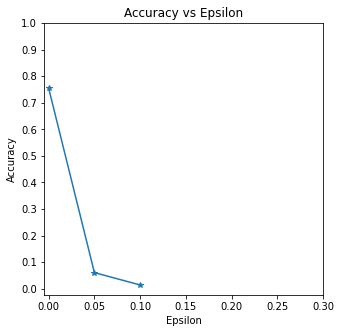

In [20]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

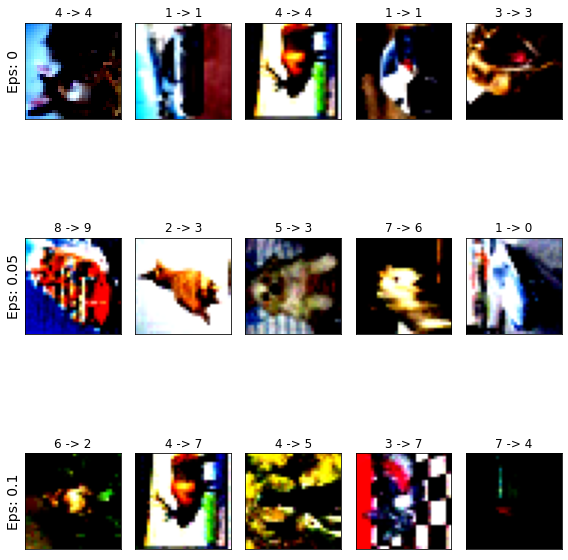

In [21]:
import matplotlib.pyplot as plt

cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex.T)
plt.tight_layout()
plt.show()

In [6]:
    
def test(test_loader, network, criterion, epoch, args, rec):
    batch_time = AverageMeter('Time', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')

    # Switch to evaluate mode
    network.eval()
    network.no_grad = True

    end = time.time()
    for i, (input, target) in enumerate(test_loader):
        target = target.to(args.device)
        input = input.to(args.device)

        # Compute output
        with torch.no_grad():
            output = network(input)

            loss = criterion(output, target).mean()

        # Measure accuracy and record loss
        prec1 = accuracy(output.data, target, topk=(1,))[0]
        losses.update(loss.data.item(), input.size(0))
        top1.update(prec1.item(), input.size(0))

        # Measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % args.print_freq == 0:
            print('Test: [{0}/{1}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                i, len(test_loader), batch_time=batch_time, loss=losses,
                top1=top1))

    print(' * Prec@1 {top1.avg:.3f}'.format(top1=top1))

    network.no_grad = False

    record_test_stats(rec, epoch, losses.avg, top1.avg)
    return top1.avg


In [10]:
from utils import *
import deepcore.datasets as datasets_deepcore

channel, im_size, num_classes, class_names, mean, std, dst_train, dst_test = datasets_deepcore.__dict__["CIFAR10"] \
            ("data")
#test_loader = torch.utils.data.DataLoader(dst_test, batch_size=128, shuffle=False,
#                                                      num_workers=15, pin_memory=True)
network = model
epoch = 200
rec = init_recorder()
criterion = nn.CrossEntropyLoss()

prec1 = test(testloader, network, criterion, epoch, args, rec)

Files already downloaded and verified
Files already downloaded and verified
Test: [0/10000]	Time 0.009 (0.009)	Loss 0.1925 (0.1925)	Prec@1 100.000 (100.000)
Test: [5/10000]	Time 0.007 (0.008)	Loss 10.8855 (2.6098)	Prec@1 0.000 (50.000)
Test: [10/10000]	Time 0.007 (0.007)	Loss 4.8228 (2.2140)	Prec@1 0.000 (54.545)
Test: [15/10000]	Time 0.007 (0.007)	Loss 0.1794 (2.0054)	Prec@1 100.000 (56.250)
Test: [20/10000]	Time 0.007 (0.007)	Loss 0.4733 (1.9030)	Prec@1 100.000 (61.905)
Test: [25/10000]	Time 0.008 (0.008)	Loss 0.0008 (1.5402)	Prec@1 100.000 (69.231)
Test: [30/10000]	Time 0.008 (0.008)	Loss 0.2201 (1.6289)	Prec@1 100.000 (67.742)
Test: [35/10000]	Time 0.008 (0.008)	Loss 3.5092 (1.6570)	Prec@1 0.000 (63.889)
Test: [40/10000]	Time 0.008 (0.008)	Loss 0.0032 (1.5911)	Prec@1 100.000 (65.854)
Test: [45/10000]	Time 0.009 (0.008)	Loss 10.6499 (1.6808)	Prec@1 0.000 (67.391)
Test: [50/10000]	Time 0.008 (0.008)	Loss 0.1176 (1.6690)	Prec@1 100.000 (64.706)
Test: [55/10000]	Time 0.009 (0.008)	Loss

KeyboardInterrupt: 

In [ ]:
testloader